# PyTorch Workflow

Let's explore a an exampl,e Pytorch end-to-end workflow

In [1]:
what_were_covering = {1:"data (prepare and load)",
                      2:"build model",
                      3:"fitting the model to data (training)",
                      4:"making predictions and evaluting a model (inference)",
                      5:"saving and loading a model",
                      6:"putting it all together"}

what_were_covering

{1: 'data (prepare and load)',
 2: 'build model',
 3: 'fitting the model to data (training)',
 4: 'making predictions and evaluting a model (inference)',
 5: 'saving and loading a model',
 6: 'putting it all together'}

In [2]:
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'2.6.0+cu124'

## Data (preparing and loading)

Data can be lmost anything... in machine learning.

* Excel spreadsheet
* Images of any kind
* Videos (YouTube has lots of data...)
* Audio like songs or podcasts
* DNA
* Text

Machine Learning is a game of two parts:
1. Get data into numerical representation.
2. Build a model to learn patterns in that numerical representtion

To showcase this, let's create some *known* data using the linear regression formula.
We'll use alinear regression formula to make a straight line with known **parameters**

In [3]:
# create *known* parameters
weight = 0.7
bias = 0.3

# Create
start =0
end =1
step=0.02
X=torch.arange(start,end,step).unsqueeze(dim=1)
y=weight*X + bias

X[:10],y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [4]:
len(X),len(y)

(50, 50)

## Splitting data into training and test sets (one of the most important concepts in machine learning in general)
Lets create a training and test with our data

In [5]:
# create a train/test split
train_split = int(0.8 * len(X))
X_train,y_train = X[:train_split],y[:train_split]
X_test,y_test = X[train_split:],y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

How might we better visulaiz e our data?

this is where the data explorer's motto comes in

"Visualize visualize visualize !"

In [6]:
def plot_predictions(train_data=X_train,train_labels=y_train,test_data=X_test,test_labels=y_test,predictions=None):

  plt.figure(figsize=(10,7))

  plt.scatter(train_data,train_labels,c='b',s=4, label ="Training Data")

  plt.scatter(test_data, test_labels, c="r",s=4,label = "Testing data")

  if predictions is not None:
    plt.scatter(test_data,predictions,c="g",s=4, label="Predictions")

  plt.legend(prop={"size":14})

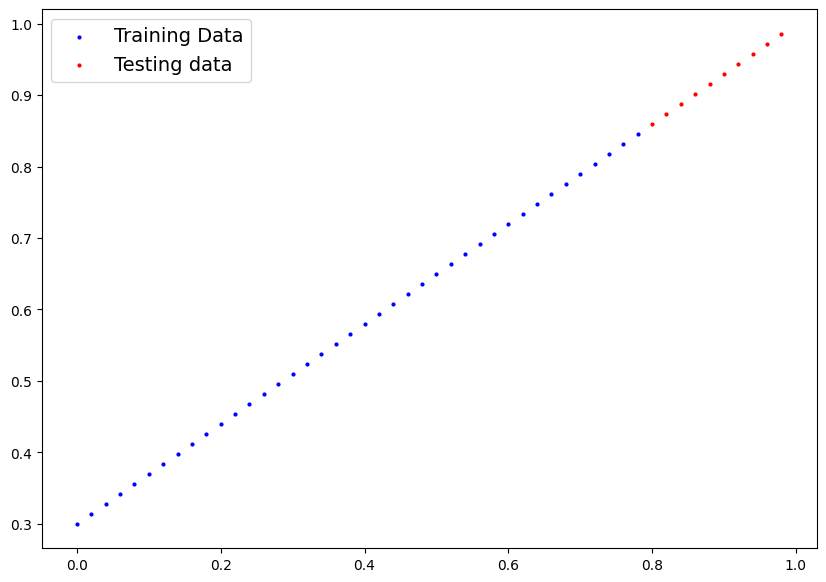

In [7]:
plot_predictions()

## Pytorch Model
what our model does:
* Start with random values (weight & bias)
* look at training data and adjust the random values to better represent (or get closer to) the ideal values(the weight & bias values we used to create the data)

how does it do so?

through two main algorithms:
1. Gradient descent
2. Backpropagation

In [8]:
# Create linear regression model class
class LinearRegressionModel(nn.Module): # <- almost everything in pytorch inhereits from nn.module
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1, # start with a random weight and try to adjust it to the ideal weight
                                            requires_grad=True, # can this parameter be updated via gradient descent
                                            dtype=torch.float)) # PyTorch loves the datatype torch.float32

    self.bias = nn.Parameter(torch.randn(1,
                                         requires_grad=True,
                                         dtype=torch.float))
  # Forward method to define the computation in the model
  def forward(self, x: torch.Tensor) -> torch.Tensor: # x is the input data
    return self.weights * x + self.bias # this is the linear regression formula

## Pytorch model building esstenials

* torch.nn - conatins all of the building for computational graphs (a neural network can be considered as computational graph)
* torch.nn.Parameter - what parameters should our model try and learn, often a Pytorch layer from torch.nn will set these for use
* torch.nn.Module -  The base class for all neural networks modules, if you subclass it you should overwrite forward()
* torch.optim - this where the optimizers in Pytorch live, they will help with gradient descent
def forward() - All nn.Module subclasses require you to overwrite fprward(), this method defines what happens in the forward computation

### Checking the contents of the first Pytorch model

Now we've created a model, let's see what's inside...

So we can check our model parameters or whats inside our model using `.parameters`

In [9]:
# Create a random seed
torch.manual_seed(42)

#Create an instance of the model (this is subclass of nn.module)
model_0 = LinearRegressionModel()

#check out  the parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [10]:
#List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [11]:
weight,bias

(0.7, 0.3)

### Making prediction using `torch.inference_mode()`
To check our model's predictive power, let's see how well it predicts `y_test` based on `X_test`
when we pass data through our model , it's going to run it through the `forward()` method

In [12]:
X_test

tensor([[0.8000],
        [0.8200],
        [0.8400],
        [0.8600],
        [0.8800],
        [0.9000],
        [0.9200],
        [0.9400],
        [0.9600],
        [0.9800]])

In [13]:
# Make predictions with model
with torch.inference_mode():
  y_preds=model_0(X_test)

# # You can also do something similar with torch.no_grad(), however inference mode is prefered
# with torch.no_grad():
#   y_preds = model_0(X_test)
y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

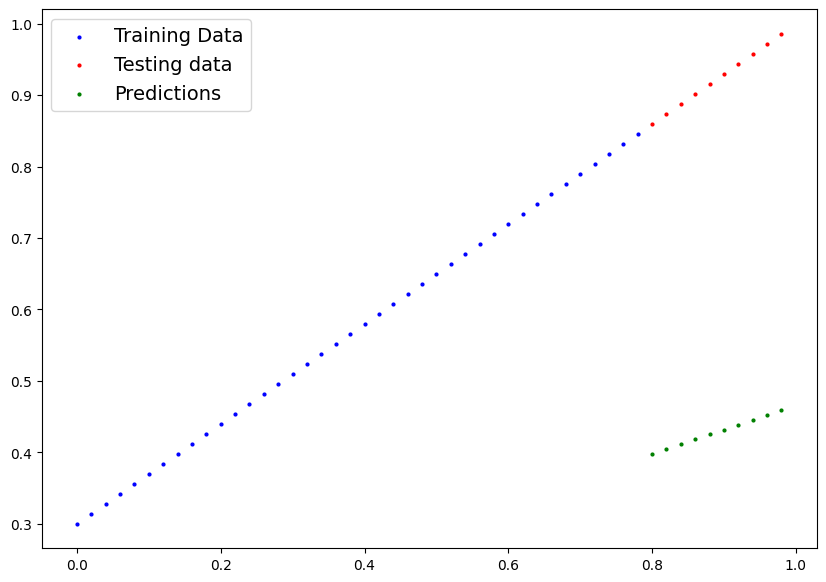

In [14]:
plot_predictions(predictions=y_preds)

### 3. Train model
the whole idea of training is for a model to move from some *unknown* parameters (these maybe random) to some *known* n parameters
or in other words from a poor representation of the data to a better representation of the data  

One way to measure how poor or how wrong your models predictions are is to use a loss function.

* Note: Loss function may also be called cost function or criterion in different areas. For our case, we re going to refer to it as loss function.

Things we need to train:
* **Loss Function:** A funtion to measure how wrong your model's predictions are to the ideal outputs, lower is better.
* **Optimizer**: Takes into account th eloss of a model parameter(eg weight,bias)

And specifically for Pytorch we need:
* A trainig loop
* A testing loop

In [15]:
# Check out our model's parameters (a parameter is a value that the model sets itself)
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [16]:
# Setup a loss function
loss_fn = nn.L1Loss()

# Set an optimizer (stochastic gradient descent)
optimizer = torch.optim.SGD(params=model_0.parameters(),lr=0.01) # lr learnong rate = possibly the most important hyperparameter you can set

### Building a trainig loop (and a testing loop) in pytorch

A couple of things we need in a training loop:
0. Loop through data
1. Forward pass (this involves datamoving through our models `forward ()` functions) to make predictions on data - also called forward propagation
2. Calculate the loss (compare forward pass predictions to ground truth labels)
3. optimizer zero grad
4. loss backward - move backwards through to caluclate the gradients of each of the paameters of our model with respect to loss(**Backpropagation**)
5. Optimizer step - use the optimizer to adjust our model's parameters to try and improve loss (**gradient**)

In [17]:
torch.manual_seed(42)

# An epoch is one loop through the data... (this is a hyperparameter because we've set )
epochs =200

# track diff things
epoch_count=[]
test_loss_value=[]
loss_value=[]
### Training
#0. Loop through the data
for epoch in range (epochs):
  #Set the model to training mode
  model_0.train() # train maode in Pytorch sets all parameters the requires gradoents require gradients
  # 1.Forward pass
  y_pred=model_0(X_train)

  # 2.Calculate the loss
  loss=loss_fn(y_pred,y_train)


  # 3.Optimizer zero grad
  optimizer.zero_grad()

  # 4.Perform backpropogation on the loss with respect to the parameters of the model
  loss.backward()

  # 5.Step the optimizer (perform gradient descent)
  optimizer.step() # by default how the optimizer changes will accumulate through the loop so... we have to zero them above in step 3

  ### Testing
  model_0.eval() # turns off different settings in the model not needed for evaluations
  with torch.inference_mode(): # turns off gradient tracking & a couple more things behind the scence
    # 1.Do the forward pass
    test_pred= model_0(X_test)

    # 2. Calculate the loss
    test_loss = loss_fn(test_pred,y_test)

  # print out whats happening
  if epoch%10==0:
    epoch_count.append(epoch)
    loss_value.append(loss)
    test_loss_value.append(test_loss)
    print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")
    # Print out model state_dict()
    print(model_0.state_dict())


Epoch: 0 | Loss: 0.31288138031959534 | Test loss: 0.48106518387794495
OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])
Epoch: 10 | Loss: 0.1976713240146637 | Test loss: 0.3463551998138428
OrderedDict([('weights', tensor([0.3796])), ('bias', tensor([0.2388]))])
Epoch: 20 | Loss: 0.08908725529909134 | Test loss: 0.21729660034179688
OrderedDict([('weights', tensor([0.4184])), ('bias', tensor([0.3333]))])
Epoch: 30 | Loss: 0.053148526698350906 | Test loss: 0.14464017748832703
OrderedDict([('weights', tensor([0.4512])), ('bias', tensor([0.3768]))])
Epoch: 40 | Loss: 0.04543796554207802 | Test loss: 0.11360953003168106
OrderedDict([('weights', tensor([0.4748])), ('bias', tensor([0.3868]))])
Epoch: 50 | Loss: 0.04167863354086876 | Test loss: 0.09919948130846024
OrderedDict([('weights', tensor([0.4938])), ('bias', tensor([0.3843]))])
Epoch: 60 | Loss: 0.03818932920694351 | Test loss: 0.08886633068323135
OrderedDict([('weights', tensor([0.5116])), ('bias', tensor([0.3788

In [18]:
with torch.inference_mode():
  ypreds_new=model_0(X_test)

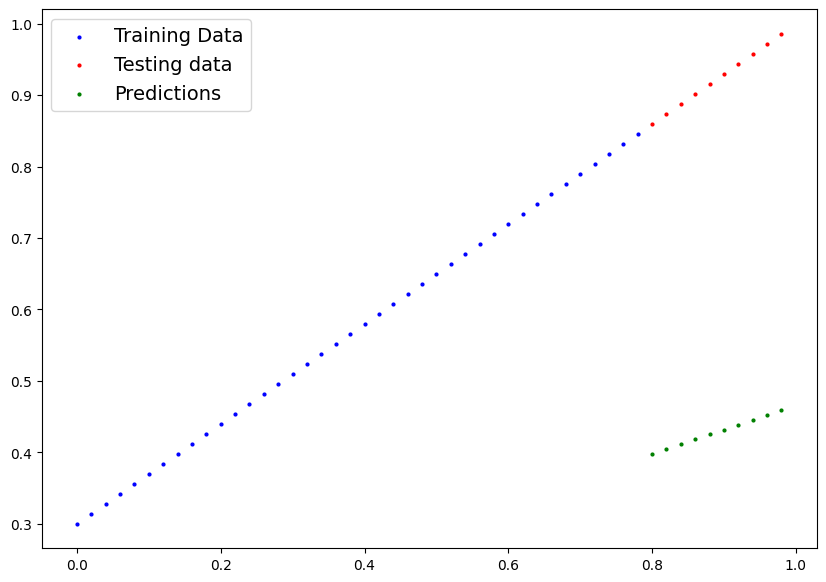

In [19]:
plot_predictions(predictions=y_preds)

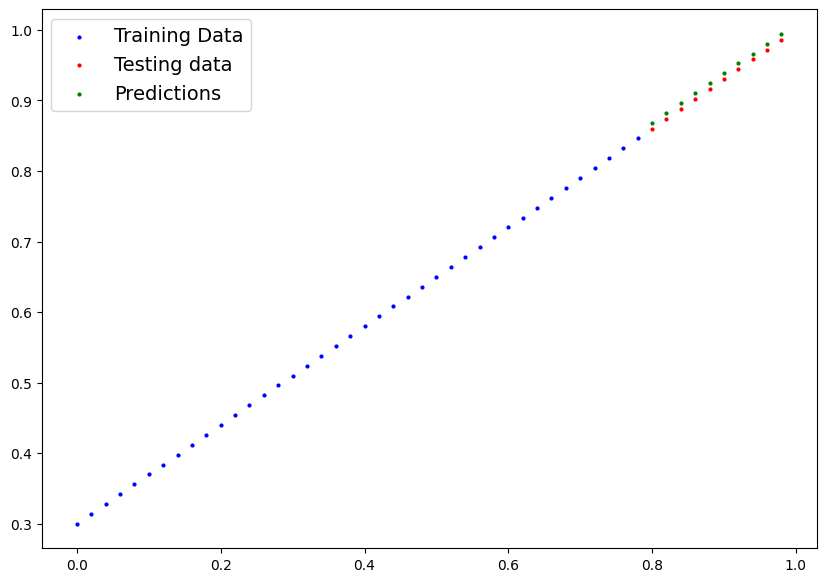

In [20]:
plot_predictions(predictions=ypreds_new)

In [21]:
import numpy as np
test_loss_value,loss_value

([tensor(0.4811),
  tensor(0.3464),
  tensor(0.2173),
  tensor(0.1446),
  tensor(0.1136),
  tensor(0.0992),
  tensor(0.0889),
  tensor(0.0806),
  tensor(0.0723),
  tensor(0.0647),
  tensor(0.0565),
  tensor(0.0482),
  tensor(0.0406),
  tensor(0.0323),
  tensor(0.0241),
  tensor(0.0165),
  tensor(0.0082),
  tensor(0.0050),
  tensor(0.0050),
  tensor(0.0050)],
 [tensor(0.3129, grad_fn=<MeanBackward0>),
  tensor(0.1977, grad_fn=<MeanBackward0>),
  tensor(0.0891, grad_fn=<MeanBackward0>),
  tensor(0.0531, grad_fn=<MeanBackward0>),
  tensor(0.0454, grad_fn=<MeanBackward0>),
  tensor(0.0417, grad_fn=<MeanBackward0>),
  tensor(0.0382, grad_fn=<MeanBackward0>),
  tensor(0.0348, grad_fn=<MeanBackward0>),
  tensor(0.0313, grad_fn=<MeanBackward0>),
  tensor(0.0279, grad_fn=<MeanBackward0>),
  tensor(0.0245, grad_fn=<MeanBackward0>),
  tensor(0.0210, grad_fn=<MeanBackward0>),
  tensor(0.0176, grad_fn=<MeanBackward0>),
  tensor(0.0142, grad_fn=<MeanBackward0>),
  tensor(0.0107, grad_fn=<MeanBackwar

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

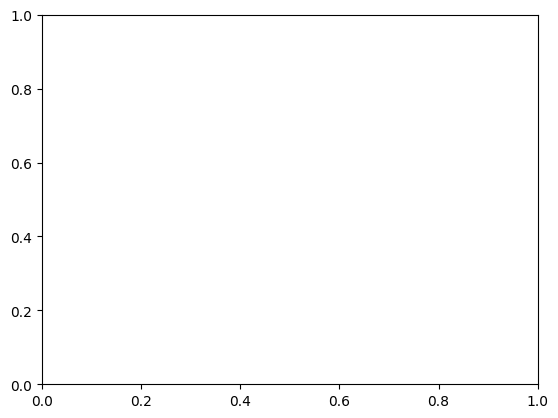

In [22]:
plt.plot(epoch_count,loss_value, label ="Train loss")
plt.plot(epoch_count,test_loss_value, label ="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

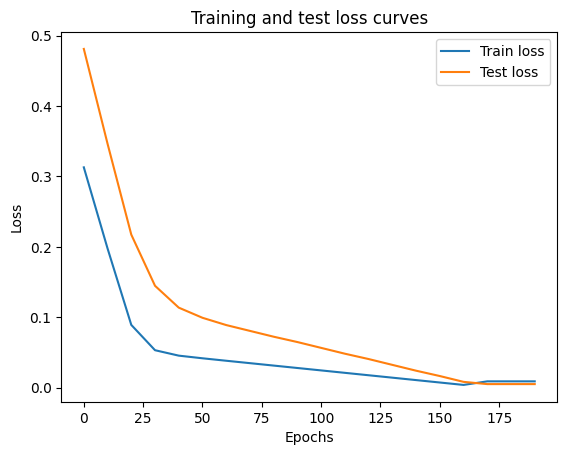

In [24]:
plt.plot(epoch_count,np.array(torch.tensor(loss_value).numpy()), label ="Train loss")
plt.plot(epoch_count,test_loss_value, label ="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

## Saving a model in Pytorch

There are three main methods you should about for saving and loading models in Pytorch

1. `torch.save()` - allows you save a pytorch object in Pythons pickle format
2. `torch.load` - allows you load a saved PyTorch object
3. `torch.nn.Module.load_state_dict()` - this allows to load a models saved state dictionary

In [25]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [26]:
# Saving our Pytorch model
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,exist_ok=True)

# 2. Create model save path
MODEL_NAME = '01_pytorch_workflow_model_0.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

MODEL_SAVE_PATH

PosixPath('models/01_pytorch_workflow_model_0.pth')

In [27]:
# 3 Save the model sate dict
print(f"Saving model to : {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to : models/01_pytorch_workflow_model_0.pth


In [28]:
!ls -l models

total 4
-rw-r--r-- 1 root root 1680 Mar 17 05:08 01_pytorch_workflow_model_0.pth


## Loading a Pytorch model
Since we saved our models state_dict() rather the entire model, we'll create a new instance of our model class and load the saved `state_dict()` into that.


In [29]:
# to load in a saved state_dict we have to instantiate a new instance of our model class
loaded_model_0 = LinearRegressionModel()

# Load the saved state_dict of model_0 {this will update the parameters}
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [30]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [31]:
# Make some predictions with our loaded model
loaded_model_0.eval()
with torch.inference_mode():
  loaded_model_preds = loaded_model_0(X_test)

loaded_model_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [32]:
# Make some models preds
model_0.eval()
with torch.inference_mode():
  y_preds=model_0(X_test)
y_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [33]:
# Compare loaded model preds with original model preds
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

### 6. Putting it all together

Lets go back through the steps above and see it all in one place.

In [34]:
import torch
from torch import nn
import matplotlib.pyplot as plt

In [35]:
# Set up device agnostic code
device ="cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


## 6.1 Data

In [36]:
weights = 0.9
bias = 0.4

In [37]:
X= torch.arange(0,1,0.03).unsqueeze(dim=1)
y= weights*X + bias

In [38]:
X

tensor([[0.0000],
        [0.0300],
        [0.0600],
        [0.0900],
        [0.1200],
        [0.1500],
        [0.1800],
        [0.2100],
        [0.2400],
        [0.2700],
        [0.3000],
        [0.3300],
        [0.3600],
        [0.3900],
        [0.4200],
        [0.4500],
        [0.4800],
        [0.5100],
        [0.5400],
        [0.5700],
        [0.6000],
        [0.6300],
        [0.6600],
        [0.6900],
        [0.7200],
        [0.7500],
        [0.7800],
        [0.8100],
        [0.8400],
        [0.8700],
        [0.9000],
        [0.9300],
        [0.9600],
        [0.9900]])

In [39]:
y

tensor([[0.4000],
        [0.4270],
        [0.4540],
        [0.4810],
        [0.5080],
        [0.5350],
        [0.5620],
        [0.5890],
        [0.6160],
        [0.6430],
        [0.6700],
        [0.6970],
        [0.7240],
        [0.7510],
        [0.7780],
        [0.8050],
        [0.8320],
        [0.8590],
        [0.8860],
        [0.9130],
        [0.9400],
        [0.9670],
        [0.9940],
        [1.0210],
        [1.0480],
        [1.0750],
        [1.1020],
        [1.1290],
        [1.1560],
        [1.1830],
        [1.2100],
        [1.2370],
        [1.2640],
        [1.2910]])

In [40]:
# Split data
train_split= int(0.8 * len(X))
X_train,y_train= X[:train_split],y[:train_split]
X_test,y_test=X[train_split:],y[train_split:]

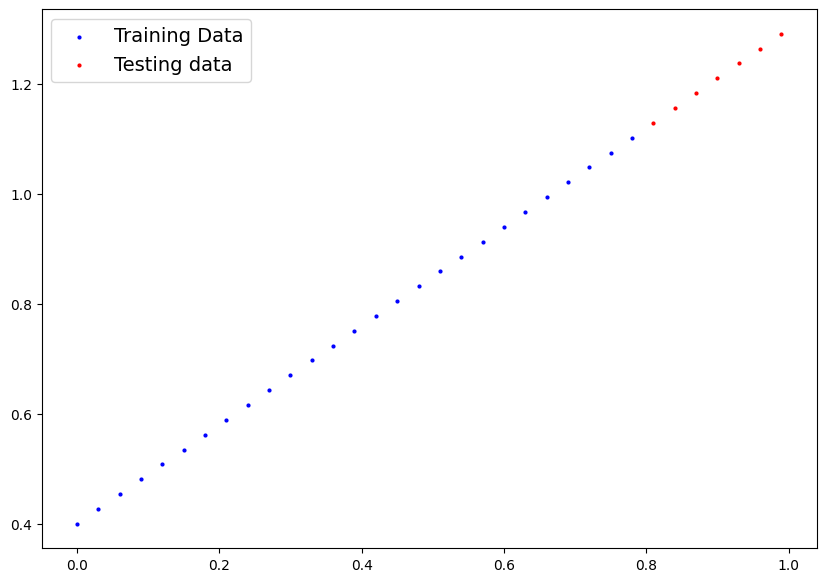

In [41]:
plot_predictions(X_train,y_train,X_test,y_test)

### 6.2 Building a Pytorch Linear model

In [42]:
class LinearRegression(nn.Module):
  def __init__(self):
    super().__init__()
    #Use nn.Linear() for creating the model parameters / also called :linear transform, probing layer , fully connecte
    self.linear_layer = nn.Linear(in_features=1,
                                   out_features=1)
  def forward(self,x:torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x)

# Set the manual seed
torch.manual_seed(42)
model_1 = LinearRegression()
model_1,model_1.state_dict()

(LinearRegression(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [43]:
device

'cpu'

In [44]:
next(model_1.parameters()).device

device(type='cpu')

In [45]:
# Set the model to use the target device
model_1.to(device)
next(model_1.parameters()).device

device(type='cpu')

### 6.3 Training
for training we need
* Loss function
* Optimizer
* Training loop
* training loop

In [46]:
# Setup loss functoin
loss_fn = nn.L1Loss() # same as MAE

# Setup our optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.01)

In [47]:
# Let's write a training loop
torch.manual_seed(42)

epochs= 200

# Put data on the target device
X_train= X_train.to(device)
y_train=y_train.to(device)
X_test=X_test.to(device)
y_test=y_test.to(device)

for epoch in range(epochs):
  model_1.train()

  # 1.forward pass
  y_pred = model_1(X_train)

  # 2. caluclate the lose
  loss = loss_fn(y_pred,y_train)

  # 3. Optmizier zero
  optimizer.zero_grad()

  #4 .Perform backpropagation
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  # testing
  model_1.eval()
  with torch.inference_mode():
    test_pred = model_1(X_test)
    test_loss = loss_fn(test_pred,y_test)

  # print out whats happening

  if epoch %10 == 0:
    print(f"Epoch: {epoch} | Loss : {loss} | Test loss: {test_loss}")



Epoch: 0 | Loss : 0.37717798352241516 | Test loss: 0.2945826053619385
Epoch: 10 | Loss : 0.26196804642677307 | Test loss: 0.15948276221752167
Epoch: 20 | Loss : 0.14675819873809814 | Test loss: 0.024382982403039932
Epoch: 30 | Loss : 0.06119358167052269 | Test loss: 0.08025850355625153
Epoch: 40 | Loss : 0.049804139882326126 | Test loss: 0.10376793891191483
Epoch: 50 | Loss : 0.045738883316516876 | Test loss: 0.10286063700914383
Epoch: 60 | Loss : 0.042083438485860825 | Test loss: 0.09885120391845703
Epoch: 70 | Loss : 0.03856373205780983 | Test loss: 0.08973802626132965
Epoch: 80 | Loss : 0.03505544736981392 | Test loss: 0.08164559304714203
Epoch: 90 | Loss : 0.03154715523123741 | Test loss: 0.073553167283535
Epoch: 100 | Loss : 0.028032217174768448 | Test loss: 0.06546071916818619
Epoch: 110 | Loss : 0.02451101504266262 | Test loss: 0.05736827850341797
Epoch: 120 | Loss : 0.020991288125514984 | Test loss: 0.048255085945129395
Epoch: 130 | Loss : 0.017482992261648178 | Test loss: 0.04

In [48]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.8907]])),
             ('linear_layer.bias', tensor([0.3982]))])

In [49]:
weights,bias

(0.9, 0.4)

### 6.4 Making And Evaluating predictions

In [50]:
# turn model into evaluation mode
model_1.eval()

# make predictions on the test data
with torch.inference_mode():
  y_preds = model_1(X_test)
y_preds

tensor([[1.1196],
        [1.1463],
        [1.1731],
        [1.1998],
        [1.2265],
        [1.2532],
        [1.2799]])

In [51]:
len(X_test)

7

In [52]:
len(y_test)

7

In [53]:
len(y_preds)

7

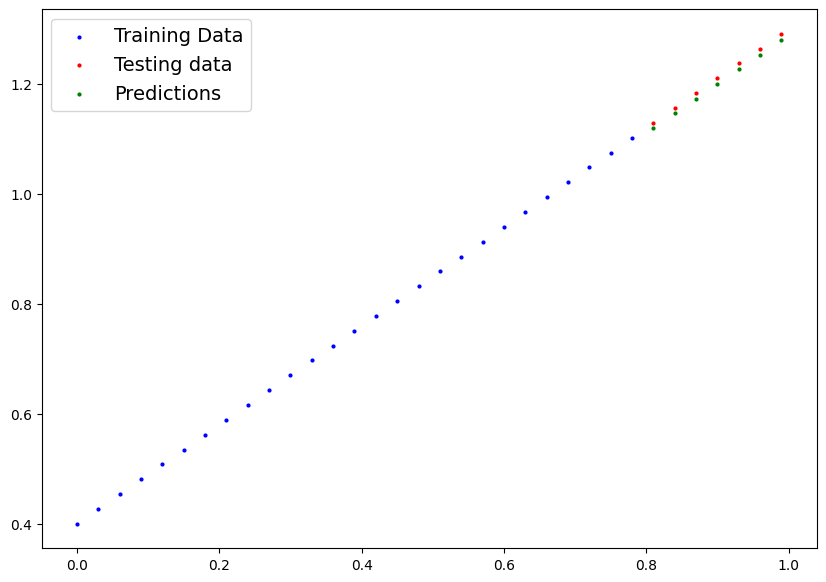

In [54]:
plot_predictions(X_train.cpu(),y_train.cpu(),X_test.cpu(),y_test.cpu(),predictions=y_preds.cpu())

### 6.5 Saving and loading a trained model

In [55]:
from pathlib import Path

# 1.Create a models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_1.pth


In [56]:
# Load Pytorch
loaded_model_1= LinearRegression()

In [57]:
loaded_model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
             ('linear_layer.bias', tensor([0.8300]))])

In [58]:
loaded_model_1.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# Put the loaded model to device
loaded_model_1.to(device)

LinearRegression(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [59]:
next(loaded_model_1.parameters()).device

device(type='cpu')

In [60]:
# Evaluate loade model
loaded_model_1.eval()
with torch.inference_mode():
  loaded_model_1_preds = loaded_model_1(X_test)
loaded_model_1_preds

tensor([[1.1196],
        [1.1463],
        [1.1731],
        [1.1998],
        [1.2265],
        [1.2532],
        [1.2799]])

In [61]:
X_test

tensor([[0.8100],
        [0.8400],
        [0.8700],
        [0.9000],
        [0.9300],
        [0.9600],
        [0.9900]])

In [117]:
weight = 0.3
bias=0.9

In [118]:
X=torch.arange(0,2,0.02)

In [119]:
X

tensor([0.0000, 0.0200, 0.0400, 0.0600, 0.0800, 0.1000, 0.1200, 0.1400, 0.1600,
        0.1800, 0.2000, 0.2200, 0.2400, 0.2600, 0.2800, 0.3000, 0.3200, 0.3400,
        0.3600, 0.3800, 0.4000, 0.4200, 0.4400, 0.4600, 0.4800, 0.5000, 0.5200,
        0.5400, 0.5600, 0.5800, 0.6000, 0.6200, 0.6400, 0.6600, 0.6800, 0.7000,
        0.7200, 0.7400, 0.7600, 0.7800, 0.8000, 0.8200, 0.8400, 0.8600, 0.8800,
        0.9000, 0.9200, 0.9400, 0.9600, 0.9800, 1.0000, 1.0200, 1.0400, 1.0600,
        1.0800, 1.1000, 1.1200, 1.1400, 1.1600, 1.1800, 1.2000, 1.2200, 1.2400,
        1.2600, 1.2800, 1.3000, 1.3200, 1.3400, 1.3600, 1.3800, 1.4000, 1.4200,
        1.4400, 1.4600, 1.4800, 1.5000, 1.5200, 1.5400, 1.5600, 1.5800, 1.6000,
        1.6200, 1.6400, 1.6600, 1.6800, 1.7000, 1.7200, 1.7400, 1.7600, 1.7800,
        1.8000, 1.8200, 1.8400, 1.8600, 1.8800, 1.9000, 1.9200, 1.9400, 1.9600,
        1.9800])

In [120]:
y=weight*X + bias

In [121]:
y

tensor([0.9000, 0.9060, 0.9120, 0.9180, 0.9240, 0.9300, 0.9360, 0.9420, 0.9480,
        0.9540, 0.9600, 0.9660, 0.9720, 0.9780, 0.9840, 0.9900, 0.9960, 1.0020,
        1.0080, 1.0140, 1.0200, 1.0260, 1.0320, 1.0380, 1.0440, 1.0500, 1.0560,
        1.0620, 1.0680, 1.0740, 1.0800, 1.0860, 1.0920, 1.0980, 1.1040, 1.1100,
        1.1160, 1.1220, 1.1280, 1.1340, 1.1400, 1.1460, 1.1520, 1.1580, 1.1640,
        1.1700, 1.1760, 1.1820, 1.1880, 1.1940, 1.2000, 1.2060, 1.2120, 1.2180,
        1.2240, 1.2300, 1.2360, 1.2420, 1.2480, 1.2540, 1.2600, 1.2660, 1.2720,
        1.2780, 1.2840, 1.2900, 1.2960, 1.3020, 1.3080, 1.3140, 1.3200, 1.3260,
        1.3320, 1.3380, 1.3440, 1.3500, 1.3560, 1.3620, 1.3680, 1.3740, 1.3800,
        1.3860, 1.3920, 1.3980, 1.4040, 1.4100, 1.4160, 1.4220, 1.4280, 1.4340,
        1.4400, 1.4460, 1.4520, 1.4580, 1.4640, 1.4700, 1.4760, 1.4820, 1.4880,
        1.4940])

In [122]:
train_limit =int( 0.8* len(X))

In [123]:
X_train,y_train = X[:train_limit].unsqueeze(dim=1),y[:train_limit].unsqueeze(dim=1)
X_test,y_test = X[train_limit:].unsqueeze(dim=1),y[train_limit:].unsqueeze(dim=1)

In [124]:
class LinearReg_test(nn.Module):
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1,dtype=torch.float),requires_grad=True)

    self.bias = nn.Parameter(torch.randn(1,dtype=torch.float),requires_grad=True)
  def forward(self, x:torch.Tensor) -> torch.Tensor:
    return self.weights * x + self.bias


In [125]:
model_test = LinearReg_test()

In [126]:
model_test.state_dict()

OrderedDict([('weights', tensor([0.3930])), ('bias', tensor([0.4327]))])

In [127]:
loss_fun= nn.L1Loss()
optimizer= torch.optim.SGD(params=model_test.parameters(),
                           lr=0.01)

In [128]:
# Training Loop

epochs=300
for epoch in range(epochs):
  model_test.train()
  y_pred=model_test(X_train)
  loss = loss_fun(y_pred,y_train)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

# testing loop
  model_test.eval()

  with torch.inference_mode():
    test_pred = model_test(X_test)
    test_loss = loss_fun(test_pred,y_test)
    if epoch % 10 == 0:
      print(f" Epoch : {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss}")

 Epoch : 0 | MAE Train Loss: 0.3938043415546417 | MAE Test Loss: 0.2766333520412445
 Epoch : 10 | MAE Train Loss: 0.23139441013336182 | MAE Test Loss: 0.03522349148988724
 Epoch : 20 | MAE Train Loss: 0.11904601752758026 | MAE Test Loss: 0.1389007568359375
 Epoch : 30 | MAE Train Loss: 0.10120580345392227 | MAE Test Loss: 0.17407800257205963
 Epoch : 40 | MAE Train Loss: 0.09125174582004547 | MAE Test Loss: 0.17290329933166504
 Epoch : 50 | MAE Train Loss: 0.08207224309444427 | MAE Test Loss: 0.1599339246749878
 Epoch : 60 | MAE Train Loss: 0.07296127825975418 | MAE Test Loss: 0.14287784695625305
 Epoch : 70 | MAE Train Loss: 0.06387066096067429 | MAE Test Loss: 0.1251421421766281
 Epoch : 80 | MAE Train Loss: 0.05477580428123474 | MAE Test Loss: 0.10672681033611298
 Epoch : 90 | MAE Train Loss: 0.04568517953157425 | MAE Test Loss: 0.08899112045764923
 Epoch : 100 | MAE Train Loss: 0.036590926349163055 | MAE Test Loss: 0.07125541567802429
 Epoch : 110 | MAE Train Loss: 0.02749970927834

In [129]:
model_test.state_dict()

OrderedDict([('weights', tensor([0.2968])), ('bias', tensor([0.8922]))])

In [130]:
with torch.inference_mode():
  y_preds = model_test(X_test)

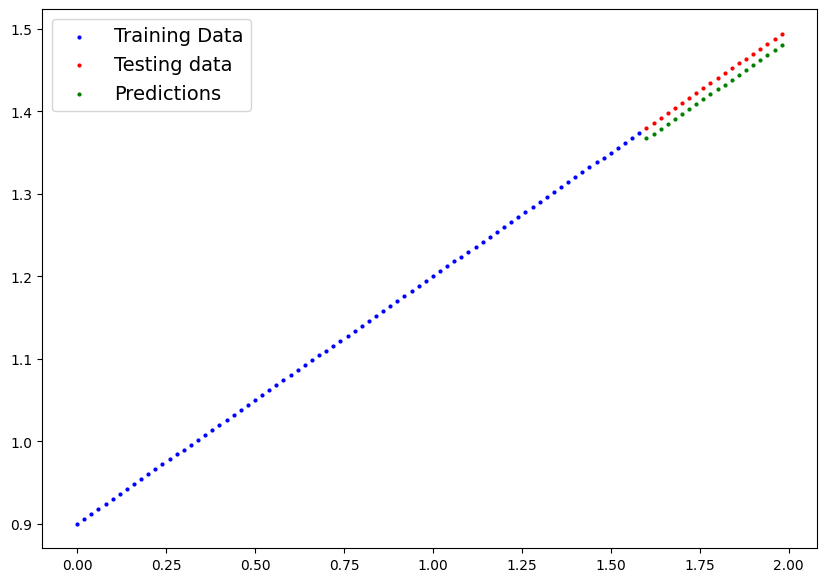

In [131]:
plot_predictions(X_train,y_train,X_test,y_test,predictions=y_preds)

In [133]:
from pathlib import Path
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents= True, exist_ok =True)

MODEL_NAME = 'test_model.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

torch.save(obj=model_test.state_dict(),
           f=MODEL_SAVE_PATH)

In [142]:
loaded_test = LinearReg_test()

In [143]:
loaded_test.state_dict()

OrderedDict([('weights', tensor([-0.3639])), ('bias', tensor([0.1513]))])

In [144]:
loaded_test.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [145]:
loaded_test.state_dict()

OrderedDict([('weights', tensor([0.2968])), ('bias', tensor([0.8922]))])

In [146]:
loaded_test.eval()
with torch.inference_mode():
  loaded_test_preds = loaded_test(X_test)
y_preds == loaded_test_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])